In [1]:
import os
import yaml
import warnings
import numpy as np
import pandas as pd

try:
    import ptype
except ImportError:
    import subprocess
    subprocess.run(["pip", "install", "git+https://github.com/ai2es/ptype-physical.git"])

from ptype.callbacks import MetricsCallback
from ptype.data import load_ptype_uq, preprocess_data
from sklearn.model_selection import GroupShuffleSplit

from evml.keras.callbacks import get_callbacks, ReportEpoch
from evml.keras.models import CategoricalDNN

2023-09-14 11:15:26.535212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 11:15:27.933118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/tensorrt_libs:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/app

In [2]:
config = "../config/ptype/deterministic.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [5]:
input_features = conf["input_features"]
output_features = conf["output_features"]

# flag for our ptype model
if all([x in conf for x in input_features]):
    input_features = [conf[x] for x in input_features]
    input_features = [item for sublist in input_features for item in sublist]

metric = conf["metric"]

In [6]:
# load data using the split (see n_splits in config)
data = load_ptype_uq(conf, data_split=0, verbose=1, drop_mixed=False)

In [7]:
scaled_data, scalers = preprocess_data(
    data,
    input_features,
    output_features,
    scaler_type=conf["scaler_type"],
    encoder_type="onehot",
    groups=[]
)

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
mlp = CategoricalDNN(**conf["model"], callbacks=[])

In [9]:
mlp.fit(scaled_data["train_x"].values, scaled_data["train_y"])

2023-09-14 11:15:30.239452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/tensorrt_libs:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64
2023-09-14 11:15:30.239508: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

6/6 [==============================] - 3s 354ms/step - loss: 215.1489


In [10]:
pred_probs = mlp.predict(scaled_data["val_x"])

10/10 [==============================] - 0s 36ms/step


In [11]:
_, ale, epi, entropy, mutual_info = mlp.predict_monte_carlo(
    scaled_data["val_x"], mc_forward_passes=10
)

### Use an evidential neural network 

In [12]:
config = "../config/ptype/evidential.yml"

In [13]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 5
conf["model"]["verbose"] = 1

In [14]:
ev_mlp = CategoricalDNN(
    **conf["model"], 
    callbacks=[ReportEpoch(conf["model"]["annealing_coeff"])]
)

In [15]:
history = ev_mlp.fit(scaled_data["train_x"], scaled_data["train_y"])

Epoch 1/5
6/6 [==============================] - 2s 155ms/step - loss: 0.7518
Epoch 2/5
6/6 [==============================] - 1s 142ms/step - loss: 0.6497
Epoch 3/5
6/6 [==============================] - 1s 150ms/step - loss: 0.5964
Epoch 4/5
6/6 [==============================] - 1s 146ms/step - loss: 0.6335
Epoch 5/5
6/6 [==============================] - 1s 150ms/step - loss: 0.6288


In [16]:
pred_probs = ev_mlp.predict(scaled_data["val_x"])

10/10 [==============================] - 0s 15ms/step


In [17]:
pred_probs, u, ale, epi = ev_mlp.compute_uncertainties(pred_probs)

In [18]:
name = "val"
pred_probs = pred_probs.numpy()
u = u.numpy()
ale = ale.numpy()
epi = epi.numpy()
true_labels = np.argmax(data[name][output_features].to_numpy(), 1)
pred_labels = np.argmax(pred_probs, 1)
confidences = np.take_along_axis(pred_probs, pred_labels[:, None], axis=1)
data[name]["true_label"] = true_labels
data[name]["pred_label"] = pred_labels
data[name]["pred_conf"] = confidences
for k in range(pred_probs.shape[-1]):
    data[name][f"pred_conf{k+1}"] = pred_probs[:, k]
data[name]["evidential"] = u
data[name]["aleatoric"] = np.take_along_axis(
    ale, pred_labels[:, None], axis=1
)
data[name]["epistemic"] = np.take_along_axis(
    epi, pred_labels[:, None], axis=1
)
for k in range(pred_probs.shape[-1]):
    data[name][f"aleatoric{k+1}"] = ale[:, k]
    data[name][f"epistemic{k+1}"] = epi[:, k]

In [19]:
true_labels = data[name]["true_label"].values
pred_labels = data[name]["pred_label"]
pred_probs = data[name][[f"pred_conf{k+1}" for k in range(4)]].values
confidences = data[name]["pred_conf"]

evidential = data[name]["evidential"]
total = np.sqrt(data[name]["epistemic"] + data[name]["aleatoric"])
epistemic = np.sqrt(data[name]["epistemic"])
aleatoric = np.sqrt(data[name]["aleatoric"])

In [20]:
from evml.classifier_uq import uq_results

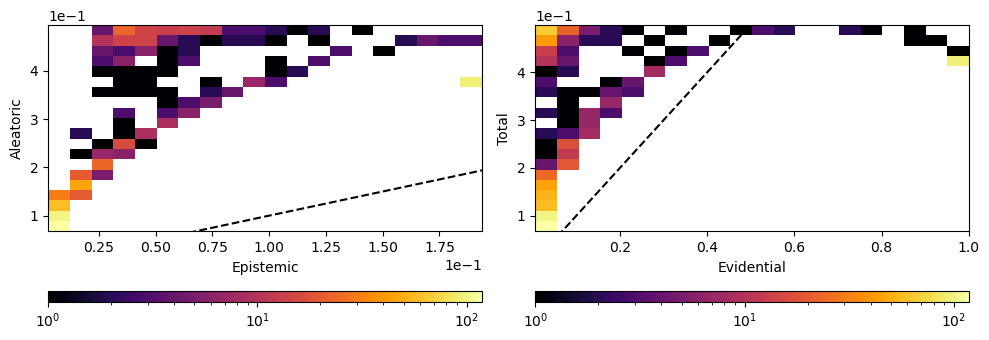

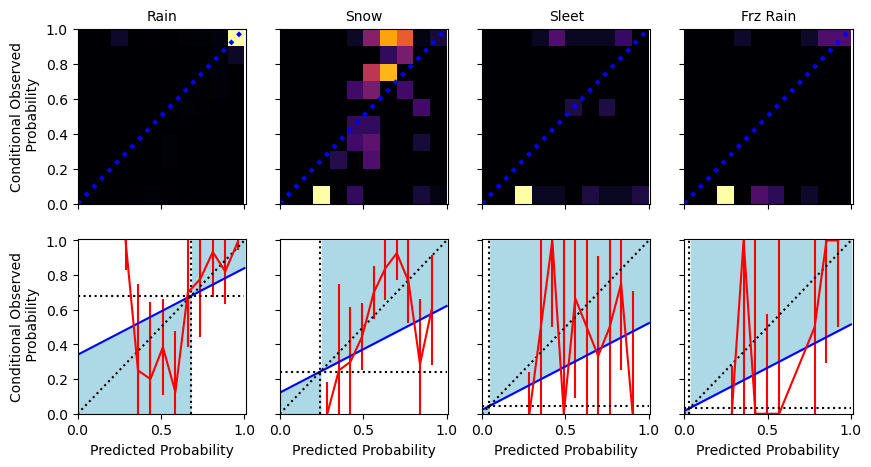

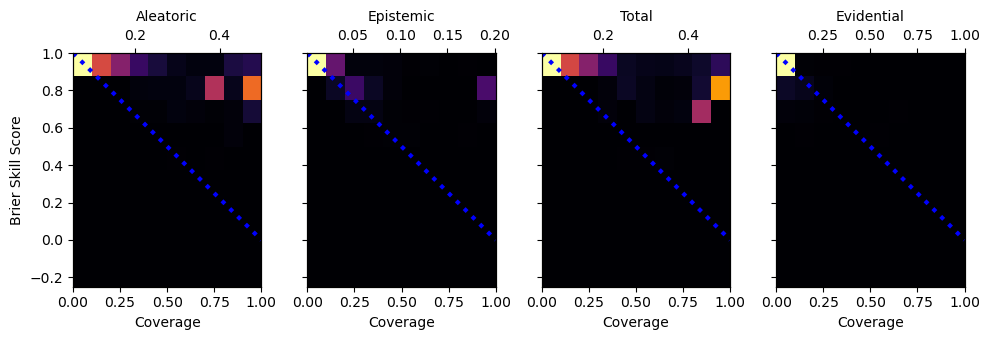

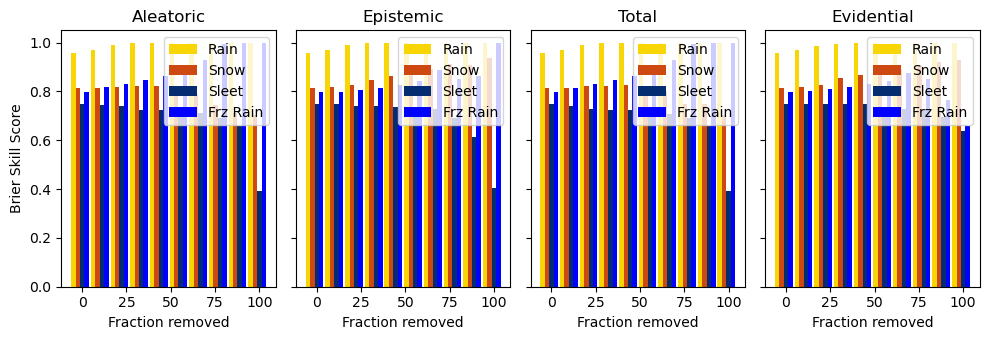

In [21]:
uq_results(data['val'], prefix='val')